In [1]:
# Each row is a census tract
# Dep variable - # trips started in tract
# Indep variables- proximity to TTC station, proximity to downtown, population density, % college degree, % unemployed, median income, median age

In [2]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt

# 2006 and 2016 Census Data Processing

In [3]:
#1-CTUID, 2-population,3-land area,15-unemployment,18-median income,16-no degree,10-mover5year
CT_2006 = pd.read_csv('./data/CT_2006.csv')[['COL1','COL2','COL3','COL15','COL18','COL16','COL10']]
CT_2006_housing = pd.read_csv('./data/CT_2006_housing.csv')[['COL1','COL2','COL3']] #1-CTUID,2 -rent, 3 value
#0-CTUID,4-density,10-unemployment,6-median income,9-no degree, 18-mover5year, 12-avgAge
CT_2016 = pd.read_csv('./data/CT_2016.csv')[['COL0','COL3','COL5','COL4','COL10','COL6','COL9','COL18','COL12']]
CT_2016_housing = pd.read_csv('./data/CT_2016_housing.csv')[['COL0','COL5','COL3']] #0-CTUID,5-rent,3-value

In [4]:
#Rename census cols
CT_2006.rename(columns={'COL1':'CTUID','COL2':'population','COL3':'landArea','COL15':'unemploymentRate','COL18':'medianIncome','COL16':'noDegree','COL10':'mover5year'},inplace=True)

In [5]:
#Merge housing census with rest of census
CT_2006_housing.rename(columns={'COL1':'CTUID','COL2':'avgRent','COL3':'homeValue'},inplace=True)
CT_2006 = CT_2006.merge(CT_2006_housing,left_on='CTUID',right_on='CTUID')

In [6]:
CT_2016.rename(columns={'COL0':'CTUID','COL3':'population','COL5':'landArea','COL4':'popDensity','COL10':'unemploymentRate','COL6':'medianIncome','COL9':'noDegree','COL18':'mover5year','COL12':'avgAge'},inplace=True)

In [7]:
CT_2016_housing.rename(columns={'COL0':'CTUID','COL5':'avgRent','COL3':'homeValue'},inplace=True)
CT_2016 = CT_2016.merge(CT_2016_housing,left_on='CTUID',right_on='CTUID')

In [8]:
#Drop first row
CT_2006 = CT_2006.iloc[1:]
CT_2016 = CT_2016.iloc[1:]
#calculate popDensity for 2006
CT_2006['popDensity'] = CT_2006['population'] / CT_2006['landArea']
#Divide noDegree, mover5year by population
CT_2006['noDegreePct'] = CT_2006['noDegree'] / CT_2006['population']*100
CT_2006['mover5yearPct'] = CT_2006['mover5year'] / CT_2006['population']*100
CT_2016['noDegreePct'] = CT_2016['noDegree'] / CT_2016['population'] *100
CT_2016['mover5yearPct'] = CT_2016['mover5year'] / CT_2016['population']*100
#Drop landArea,noDegree,mover5year cols
CT_2006.drop(['population','landArea','noDegree','mover5year'],axis=1,inplace=True)
CT_2016.drop(['population','landArea','noDegree','mover5year'],axis=1,inplace=True)

In [9]:
#Round
CT_2006 = CT_2006.round({'popDensity':1,'noDegreePct':1,'mover5yearPct':1,})
CT_2016 = CT_2016.round({'popDensity':1,'noDegreePct':1,'mover5yearPct':1,})

In [10]:
CT_2006.head()

,CTUID,unemploymentRate,medianIncome,avgRent,homeValue,popDensity,noDegreePct,mover5yearPct
1,5350001.0,8.5,26518.0,1034.0,317361.0,93.6,7.9,43.8
2,5350002.0,4.3,25168.0,1138.0,206000.0,197.8,4.0,12.8
3,5350004.0,9.6,18160.0,783.0,432564.0,20179.4,12.2,57.8
4,5350005.0,10.5,15201.0,681.0,410776.0,13392.1,9.4,46.2
5,5350006.0,NaN,NaN,NaN,NaN,15600.0,NaN,NaN


In [11]:
CT_2016.head()

,CTUID,popDensity,unemploymentRate,medianIncome,avgAge,avgRent,homeValue,noDegreePct,mover5yearPct
1,5350001.0,97.6,6.2,41165.0,39.3,1738.0,698920.0,1.7,35.3
2,5350002.0,195.4,9.8,38016.0,48.7,984.0,424642.0,0.0,22.6
3,5350003.0,820.5,7.5,50048.0,49.8,1842.0,402808.0,2.0,41.4
4,5350004.0,19453.0,9.8,22315.0,40.0,1013.0,1031075.0,10.4,45.9
5,5350005.0,17076.0,7.4,28152.0,39.1,1068.0,585186.0,7.1,48.6


## 2006 and 2016 Census Tract Shape Files

In [12]:
CT_2006_shp = geopandas.read_file("./data/gct_000b06a_e.shp")[['CTUID','geometry']]
CT_2016_shp = geopandas.read_file("./data/lct_000b16a_e.shp")[['CTUID','geometry']]
CT_2006_shp = CT_2006_shp.to_crs("EPSG:3347")
CT_2016_shp = CT_2016_shp.to_crs("EPSG:3347")

In [13]:
#CT_2016_shp = geopandas.read_file("./data/lct_000b16a_e.shp")[['CTUID','CMANAME','geometry']]
#CT_2016_shp = CT_2016_shp[CT_2016_shp['CMANAME'] == 'Toronto']
#np.shape(CT_2016_shp)

In [14]:
#CT_2016_shp = CT_2016_shp[CT_2016_shp['CMANAME'] == 'Toronto']
CT_2016_shp['CTUID'] = CT_2016_shp['CTUID'].astype(float)
CT_2016_shp = CT_2016_shp[CT_2016_shp.CTUID.isin(CT_2016.CTUID)]

In [15]:
CT_2006_shp['CTUID'] = CT_2006_shp['CTUID'].astype(float)
#CT_2006_shp['geometry'] = CT_2006_shp.geometry.buffer(7.4)
#CT_2016_shp['geometry'] = CT_2016_shp.geometry.buffer(0.5)
CT_2006_shp = CT_2006_shp[CT_2006_shp.CTUID.isin(CT_2006.CTUID)]
CT_2006_shp_less = CT_2006_shp[~CT_2006_shp.CTUID.isin(CT_2016.CTUID)]
#print(CT_2006_shp_less['CTUID'].values)
#CT_both = geopandas.sjoin(CT_2016_shp, CT_2006_shp, how='left',op='intersects')
CT_both = geopandas.sjoin(CT_2016_shp, CT_2006_shp_less, how='right',op='intersects')
#print(np.shape(CT_both))
#Remove any with nan values
CT_both = CT_both.dropna()
CT_both = CT_both.drop_duplicates(subset=['CTUID_x'])
CT_both = CT_both.drop_duplicates(subset=['CTUID_y'])
#CT_2006_shp_less.boundary.plot()
#CT_both.boundary.plot()
CT_both = CT_both.merge(CT_2006, left_on='CTUID_y', right_on='CTUID')
CT_both = CT_both.drop(['index_left','CTUID_y','CTUID'],axis=1)

In [16]:
CT_2006_merge = CT_2006_shp.merge(CT_2006, on='CTUID')
print(np.shape(CT_2006_merge))
CT_2006_merge.head()

(998, 9)


,CTUID,geometry,unemploymentRate,medianIncome,avgRent,homeValue,popDensity,noDegreePct,mover5yearPct
0,5350001.0,"POLYGON ((7230991.536 931221.701, 7230993.001 ...",8.5,26518.0,1034.0,317361.0,93.6,7.9,43.8
1,5350002.0,"MULTIPOLYGON (((7227690.530 927052.443, 722784...",4.3,25168.0,1138.0,206000.0,197.8,4.0,12.8
2,5350004.0,"POLYGON ((7220893.888 926061.141, 7220934.950 ...",9.6,18160.0,783.0,432564.0,20179.4,12.2,57.8
3,5350005.0,"POLYGON ((7222000.055 926685.368, 7222007.385 ...",10.5,15201.0,681.0,410776.0,13392.1,9.4,46.2
4,5350006.0,"POLYGON ((7221223.863 925932.776, 7221108.985 ...",NaN,NaN,NaN,NaN,15600.0,NaN,NaN


(101, 9)
(1099, 9)


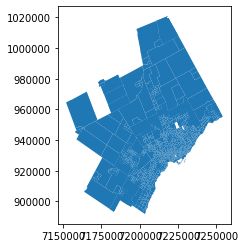

In [17]:
CT_both.rename(columns={'CTUID_x':'CTUID'},inplace=True)
print(np.shape(CT_both))
CT_both.head()
CT_2006_new = pd.concat([CT_2006_merge,CT_both])
print(np.shape(CT_2006_new))
CT_2006_new.plot()

In [18]:
#For the 104 CTUIDs values in CT_both, replace the correspondding value in CT_2006_shp
#CT_2006_shp['CTUID'] = CT_2006_shp['CTUID'].map(CT_both.set_index('CTUID_y')['CTUID_x'])
#CT_both.head()
#print(np.shape(CT_2006_shp))
#CT_2006_shp.head()

(1151, 10)


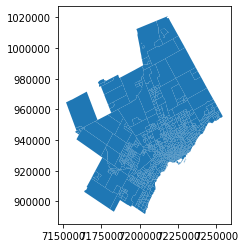

In [19]:
CT_2016_merge = CT_2016_shp.merge(CT_2016, on='CTUID')
print(np.shape(CT_2016_merge))
CT_2016_merge.head()
CT_2016_merge.plot()

(1221, 18)


,CTUID,geometry_2016,popDensity_2016,unemploymentRate_2016,medianIncome_2016,avgAge,avgRent_2016,homeValue_2016,noDegreePct_2016,mover5yearPct_2016,geometry_2006,unemploymentRate_2006,medianIncome_2006,avgRent_2006,homeValue_2006,popDensity_2006,noDegreePct_2006,mover5yearPct_2006
0,5350422.06,"POLYGON ((7215728.211 952217.103, 7215620.917 ...",2836.5,8.2,23509.0,45.2,1039.0,728609.0,3.2,38.7,"POLYGON ((7217271.081 953042.228, 7217117.423 ...",4.0,17346.0,661.0,328552.0,2783.2,4.6,36.2
1,5350420.13,"POLYGON ((7218613.794 949619.114, 7218679.703 ...",2965.1,6.0,31155.0,40.1,1554.0,606979.0,1.4,38.4,"POLYGON ((7218800.039 949137.877, 7218751.363 ...",3.9,43716.0,933.0,343762.0,2336.1,3.1,48.2
2,5350420.13,"POLYGON ((7218613.794 949619.114, 7218679.703 ...",2965.1,6.0,31155.0,40.1,1554.0,606979.0,1.4,38.4,"POLYGON ((7218446.194 950022.257, 7218335.862 ...",5.9,31520.0,1320.0,437590.0,4142.2,4.2,58.3
3,5350422.03,"POLYGON ((7219855.811 954804.291, 7219916.443 ...",1939.6,6.9,30528.0,37.3,2000.0,929606.0,2.5,27.9,"POLYGON ((7219993.666 954416.954, 7219959.061 ...",3.9,40386.0,1451.0,423834.0,1532.5,4.9,73.6
4,5350422.04,"POLYGON ((7217954.586 954686.897, 7217969.586 ...",4613.4,5.0,26768.0,38.9,1951.0,1025240.0,3.3,23.8,"POLYGON ((7219101.704 953926.088, 7218927.412 ...",4.9,26130.0,1185.0,445004.0,4300.0,3.5,39.2


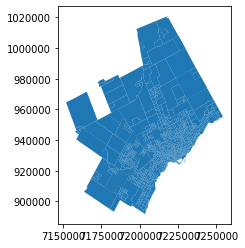

In [20]:
CT_merge = CT_2016_merge.merge(CT_2006_new,how='left',left_on='CTUID',right_on='CTUID',suffixes=('_2016', '_2006'))
#CT_merge = CT_merge.dropna()
CT_merge_gdf = geopandas.GeoDataFrame(CT_merge,crs='EPSG:3347',geometry='geometry_2016')
CT_merge_gdf.plot()
print(np.shape(CT_merge))
CT_merge.head()

In [21]:
#CT_merge = CT_merge.dropna()
#CT_merge['geometry_2016'] = CT_merge['geometry_2016'].apply(wkt.loads)
#CT_merge_gdf = geopandas.GeoDataFrame(CT_merge,crs='EPSG:3347',geometry='geometry_2016')
#CT_merge_gdf.rename(columns={'geometry_2016':'geometry'},inplace=True)
#CT_merge_gdf.set_geometry('geometry')
#np.shape(CT_merge)

# TTC Station Data Processing

<class 'geopandas.geodataframe.GeoDataFrame'>


,geometry
0,POINT (7212793.235 924484.220)
1,POINT (7213526.825 925559.542)
2,POINT (7214541.005 926092.598)
3,POINT (7215816.168 926558.257)
4,POINT (7216686.174 926691.977)
5,POINT (7217307.112 927025.367)
6,POINT (7218074.111 927452.994)
7,POINT (7218552.877 927725.075)
8,POINT (7219125.995 928021.490)
9,POINT (7219876.950 928392.131)


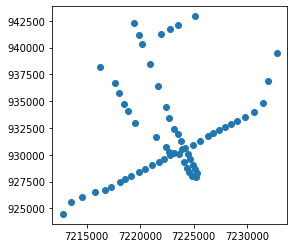

In [22]:
ttc_shp = geopandas.read_file("./data/TTC_SubwayStns_20120119/subwayStations.shp")[['geometry']]
print(type(ttc_shp))
ttc_shp = ttc_shp.to_crs("EPSG:3347")
base1 = ttc_shp.plot()
ttc_shp.head(50)

In [23]:
#CT_merge_gdf.rename(columns={'geometry_2016':'geometry'},inplace=True)
#CT_merge_gdf['geometry'] = CT_merge_gdf['geometry_2016'].centroid
#CT_merge_gdf.set_geometry('geometry')


In [24]:
from scipy.spatial import cKDTree
from shapely.geometry import Point

def ckdnearest(gdA, gdB,col_name):
    #Use centroid of each census tract
    nA = np.array(list(zip(gdA.geometry.centroid.x, gdA.geometry.centroid.y)) ) 
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )

    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name=col_name)], axis=1)
    return gdf

CT_merge_gdf = ckdnearest(CT_merge_gdf, ttc_shp,'proximityTTC')

# Proximity to Downtown

In [25]:
gpd2 = geopandas.GeoDataFrame([[Point(7224367.945,928799.143)]],crs='EPSG:3347',columns=['geometry'])
#gpd2 = gpd2.to_crs("EPSG:3347")
#Point(7224367.945,928799.143)
print(gpd2)
CT_merge_gdf = ckdnearest(CT_merge_gdf, gpd2,'proximityDowntown')

                         geometry
0  POINT (7224367.945 928799.143)


(1221, 18)


Index(['CTUID', 'geometry_2016', 'popDensity_2016', 'unemploymentRate_2016',
       'medianIncome_2016', 'avgAge', 'avgRent_2016', 'homeValue_2016',
       'noDegreePct_2016', 'mover5yearPct_2016', 'geometry_2006',
       'unemploymentRate_2006', 'medianIncome_2006', 'avgRent_2006',
       'homeValue_2006', 'popDensity_2006', 'noDegreePct_2006',
       'mover5yearPct_2006', 'proximityTTC', 'proximityDowntown'],
      dtype='object')

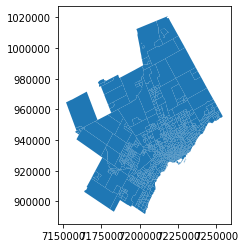

In [26]:
CT_merge_gdf.set_geometry('geometry_2016')
#CT_merge_gdf = CT_merge_gdf.dropna()
CT_merge_gdf = CT_merge_gdf.drop_duplicates(subset=['geometry_2016'])
CT_merge_gdf.plot()
print(np.shape(CT_merge))
CT_merge_gdf.columns

# Historical Ridership Data Processing

In [27]:
df = pd.read_csv('./data/trips.csv')
df_counts = df.groupby('Station Id From')['Id'].count().reset_index()
df_counts.rename(columns={'Id':'numRides'},inplace=True)
df = df.drop_duplicates('Station Id From')

In [28]:
rides_gdf = geopandas.GeoDataFrame(df,crs='EPSG:4326', geometry=geopandas.points_from_xy(df['Lon From_x'], df['Lat From_x']))
rides_gdf = rides_gdf.to_crs("EPSG:3347")

In [29]:
rides_gdf = rides_gdf.merge(df_counts,left_on='Station Id From',right_on='Station Id From')
rides_gdf = rides_gdf[['geometry','numRides']]
print(np.shape(rides_gdf))
rides_gdf.head()

(357, 2)


,geometry,numRides
0,POINT (7224789.457 927339.372),9626
1,POINT (7221593.108 928208.845),3652
2,POINT (7224465.757 929428.142),8958
3,POINT (7224773.147 928512.375),9166
4,POINT (7224265.860 928974.351),6593


In [30]:
rides_gdf['numRides'].sum()

1798834

In [31]:
#rides_in_CT = geopandas.sjoin(CT_merge_gdf,rides_gdf, how="inner", op='contains')
rides_in_CT = geopandas.sjoin(CT_merge_gdf,rides_gdf, how="left", op='contains')
rides_in_CT['numRides'].fillna(0)
rides_in_CT.drop(['index_right','geometry_2016','geometry_2006'],axis=1,inplace=True)

In [32]:
print(np.shape(rides_in_CT))
print(rides_in_CT.columns)
print(rides_in_CT['numRides'].sum())
rides_in_CT.tail(10)

(1382, 19)
Index(['CTUID', 'popDensity_2016', 'unemploymentRate_2016',
       'medianIncome_2016', 'avgAge', 'avgRent_2016', 'homeValue_2016',
       'noDegreePct_2016', 'mover5yearPct_2016', 'unemploymentRate_2006',
       'medianIncome_2006', 'avgRent_2006', 'homeValue_2006',
       'popDensity_2006', 'noDegreePct_2006', 'mover5yearPct_2006',
       'proximityTTC', 'proximityDowntown', 'numRides'],
      dtype='object')
1790796.0


,CTUID,popDensity_2016,unemploymentRate_2016,medianIncome_2016,avgAge,avgRent_2016,homeValue_2016,noDegreePct_2016,mover5yearPct_2016,unemploymentRate_2006,medianIncome_2006,avgRent_2006,homeValue_2006,popDensity_2006,noDegreePct_2006,mover5yearPct_2006,proximityTTC,proximityDowntown,numRides
1211,5350376.12,5829.2,11.3,25051.0,46.6,1339.0,539597.0,7.1,30.7,8.0,34032.0,981.0,278515.0,6051.6,6.4,41.2,3381.765750,17358.429906,NaN
1212,5350411.26,5247.4,5.5,37584.0,34.5,1929.0,708242.0,6.0,24.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13588.296962,26834.972161,NaN
1213,5350411.27,3690.1,5.2,34197.0,37.1,1305.0,836807.0,6.3,20.7,3.5,31468.0,1204.0,414660.0,3536.0,8.8,35.7,12932.200749,26110.463355,NaN
1214,5350159.01,7081.6,11.0,25915.0,40.4,1099.0,598933.0,21.1,32.5,10.1,24418.0,886.0,301373.0,7561.2,20.4,39.8,3253.034021,7616.506945,NaN
1215,5350159.02,8209.6,6.7,27703.0,40.5,1069.0,543911.0,19.5,29.6,4.0,25043.0,915.0,310060.0,8429.8,21.0,29.8,2820.945984,7317.673835,NaN
1216,5350225.01,5330.1,6.2,39450.0,46.8,1353.0,797424.0,3.6,39.9,4.8,44657.0,1103.0,478212.0,5226.9,3.6,43.3,676.223076,11858.106955,NaN
1217,5350225.02,31843.8,8.8,29591.0,39.6,1182.0,334917.0,4.6,54.6,11.1,21036.0,840.0,234156.0,21250.0,5.8,63.3,331.209480,11645.034015,NaN
1218,5350260.04,22046.8,11.9,17920.0,35.4,1079.0,0.0,7.2,45.2,17.8,14333.0,913.0,0.0,21516.7,4.6,66.1,3656.618749,8227.894368,NaN
1219,5350301.03,25398.4,12.2,21483.0,33.3,1438.0,326520.0,2.7,69.6,11.4,21023.0,1113.0,149547.0,18163.0,2.1,71.9,393.055114,13860.082396,NaN
1220,5350301.04,4107.8,10.1,23872.0,35.4,1348.0,346852.0,3.8,62.4,10.9,22626.0,1083.0,210290.0,2495.8,2.6,64.1,1191.565860,14030.058577,NaN


In [33]:
CT_merge_gdf=rides_in_CT.groupby(['CTUID'], as_index=False).agg({'numRides': 'sum', 'popDensity_2016': 'first', 'unemploymentRate_2016': 'first',
                                           'medianIncome_2016': 'first','avgAge': 'first','avgRent_2016': 'first',
                                           'homeValue_2016': 'first','noDegreePct_2016': 'first','mover5yearPct_2016': 'first',
                                           'unemploymentRate_2006': 'first','medianIncome_2006': 'first','avgRent_2006': 'first',
                                           'homeValue_2006': 'first','popDensity_2006': 'first','noDegreePct_2006': 'first',
                                           'mover5yearPct_2006': 'first','proximityTTC': 'first','proximityDowntown': 'first'})

In [34]:
#125 census tracts contain 356 Bike Lanes
print(np.shape(CT_merge_gdf))
print(CT_merge_gdf['numRides'].sum())
CT_merge_gdf.tail(100)
#test.head()

(1151, 19)
1790796.0


,CTUID,numRides,popDensity_2016,unemploymentRate_2016,medianIncome_2016,avgAge,avgRent_2016,homeValue_2016,noDegreePct_2016,mover5yearPct_2016,unemploymentRate_2006,medianIncome_2006,avgRent_2006,homeValue_2006,popDensity_2006,noDegreePct_2006,mover5yearPct_2006,proximityTTC,proximityDowntown
1051,5350612.11,0.0,2379.2,5.8,46016.0,37.5,2003.0,868521.0,1.2,26.5,5.0,74087.0,1797.0,502936.0,2464.8,2.0,35.1,25910.758261,36140.035944
1052,5350612.12,0.0,3812.2,5.6,42144.0,37.4,1481.0,752674.0,2.0,24.7,4.7,49949.0,1276.0,392418.0,3790.3,2.4,29.3,24751.446386,35011.875379
1053,5350612.13,0.0,3141.0,6.7,44352.0,43.0,1622.0,777188.0,0.7,26.5,4.8,47579.0,1426.0,422486.0,3375.8,3.1,34.1,27564.347374,37324.185573
1054,5350612.14,0.0,2011.1,7.8,40384.0,38.9,1609.0,771373.0,2.5,28.7,5.3,45504.0,1465.0,383210.0,2107.5,2.8,32.9,27994.082562,37585.937092
1055,5350612.15,0.0,1751.1,5.0,51994.0,35.5,2352.0,881162.0,1.2,42.8,7.0,53884.0,1451.0,380464.0,391.9,2.5,87.1,31549.141688,41607.427042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,5350820.07,0.0,3017.2,8.7,38894.0,39.1,907.0,659756.0,3.2,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21810.275746,35368.779031
1147,5350830.00,0.0,24.6,5.2,38726.0,43.8,1397.0,845168.0,3.8,32.5,3.2,31192.0,899.0,510415.0,21.9,7.5,27.5,34223.076119,48181.386233
1148,5350831.01,0.0,475.3,7.5,41344.0,39.7,1125.0,586877.0,3.5,27.5,3.3,26161.0,775.0,370839.0,434.8,3.3,36.5,43378.265823,57337.851813
1149,5350831.02,0.0,385.4,4.7,39534.0,44.9,1105.0,614733.0,3.3,35.3,5.4,36002.0,930.0,360302.0,323.7,4.0,41.9,40851.520216,54683.987456


# Changing 2006 Census Data to Rate of Change between 2006 and 2016

In [35]:
CT_merge_gdf['popDensity_change'] = CT_merge_gdf['popDensity_2016'] - CT_merge_gdf['popDensity_2006']
CT_merge_gdf['unemploymentRate_change'] = CT_merge_gdf['unemploymentRate_2016'] - CT_merge_gdf['unemploymentRate_2006']
CT_merge_gdf['medianIncome_change'] = CT_merge_gdf['medianIncome_2016'] - CT_merge_gdf['medianIncome_2006']
CT_merge_gdf['avgRent_change'] = CT_merge_gdf['avgRent_2016'] - CT_merge_gdf['avgRent_2006']
CT_merge_gdf['homeValue_change'] = CT_merge_gdf['homeValue_2016'] - CT_merge_gdf['homeValue_2006']
CT_merge_gdf['noDegreePct_change'] = CT_merge_gdf['noDegreePct_2016'] - CT_merge_gdf['noDegreePct_2006']
CT_merge_gdf['mover5yearPct_change'] = CT_merge_gdf['mover5yearPct_2016'] - CT_merge_gdf['mover5yearPct_2006']

In [36]:
#dropna
CT_merge_gdf.drop(['popDensity_2006','unemploymentRate_2006','medianIncome_2006','avgRent_2006','homeValue_2006','noDegreePct_2006','mover5yearPct_2006'],axis=1,inplace=True)
CT_merge_gdf = CT_merge_gdf.dropna()
print(np.shape(CT_merge_gdf))
print(CT_merge_gdf['numRides'].sum())

(919, 19)
1323173.0


In [37]:
print(CT_merge_gdf.columns)
CT_merge_gdf.head()

Index(['CTUID', 'numRides', 'popDensity_2016', 'unemploymentRate_2016',
       'medianIncome_2016', 'avgAge', 'avgRent_2016', 'homeValue_2016',
       'noDegreePct_2016', 'mover5yearPct_2016', 'proximityTTC',
       'proximityDowntown', 'popDensity_change', 'unemploymentRate_change',
       'medianIncome_change', 'avgRent_change', 'homeValue_change',
       'noDegreePct_change', 'mover5yearPct_change'],
      dtype='object')


,CTUID,numRides,popDensity_2016,unemploymentRate_2016,medianIncome_2016,avgAge,avgRent_2016,homeValue_2016,noDegreePct_2016,mover5yearPct_2016,proximityTTC,proximityDowntown,popDensity_change,unemploymentRate_change,medianIncome_change,avgRent_change,homeValue_change,noDegreePct_change,mover5yearPct_change
0,5350001.00,7179.0,97.6,6.2,41165.0,39.3,1738.0,698920.0,1.7,35.3,3516.462526,4456.761918,4.0,-2.3,14647.0,704.0,381559.0,-6.2,-8.5
1,5350002.00,0.0,195.4,9.8,38016.0,48.7,984.0,424642.0,0.0,22.6,2578.662374,3648.369014,-2.4,5.5,12848.0,-154.0,218642.0,-4.0,9.8
3,5350004.00,2631.0,19453.0,9.8,22315.0,40.0,1013.0,1031075.0,10.4,45.9,2461.800066,4691.802067,-726.4,0.2,4155.0,230.0,598511.0,-1.8,-11.9
4,5350005.00,7568.0,17076.0,7.4,28152.0,39.1,1068.0,585186.0,7.1,48.6,2350.184647,3878.398693,3683.9,-3.1,12951.0,387.0,174410.0,-2.3,2.4
6,5350007.01,2876.0,16233.7,7.0,28245.0,39.2,1026.0,831840.0,8.8,45.1,2798.265040,4257.871769,-1841.3,-0.9,6379.0,231.0,401895.0,1.6,-2.3


# Linear Regression Model

In [38]:
# imports
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

# allow plots to appear directly in the notebook
%matplotlib inline

In [39]:
### STATSMODELS ###

# create a fitted model with all three features
lm1 = smf.ols(formula='numRides ~ popDensity_2016 + unemploymentRate_2016 + medianIncome_2016 + avgAge + avgRent_2016 + homeValue_2016 + noDegreePct_2016 + mover5yearPct_2016 + unemploymentRate_change + medianIncome_change + avgRent_change + homeValue_change + popDensity_change + noDegreePct_change + mover5yearPct_change + proximityTTC + proximityDowntown', data=CT_merge_gdf).fit()

# print the coefficients
lm1.params

Intercept                  15067.327771
popDensity_2016               -0.318891
unemploymentRate_2016       -319.091703
medianIncome_2016             -0.076011
avgAge                      -111.246036
avgRent_2016                   4.124729
homeValue_2016                -0.014613
noDegreePct_2016            -263.351457
mover5yearPct_2016           215.828181
unemploymentRate_change     -112.834429
medianIncome_change            0.001972
avgRent_change                -1.783739
homeValue_change               0.020501
popDensity_change              1.553020
noDegreePct_change           348.783629
mover5yearPct_change          23.326858
proximityTTC                   0.864879
proximityDowntown             -0.872676
dtype: float64

In [40]:
### STATSMODELS ###

# print a summary of the fitted model
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               numRides   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     26.39
Date:                Wed, 15 Apr 2020   Prob (F-statistic):           1.47e-67
Time:                        19:03:30   Log-Likelihood:                -9507.6
No. Observations:                 919   AIC:                         1.905e+04
Df Residuals:                     901   BIC:                         1.914e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.507e+04   5673.422      2.656      0.008    3932.667    2.62e+04
popDensity_2016            -0.3189      0.075     -4.228      0.000      -0.467      -0.171
unemploymentRate_2016    -319.0917    182.010     -1.753      0.080    -676.304      38.121
medianIncome_2016          -0.0760      0.049     -1.553      0.121      -0.172       0.020
avgAge                   -111.2460     83.183     -1.337      0.181    -274.501      52.009
avgRent_2016                4.1247      1.260      3.272      0.001       1.651       6.599
homeValue_2016             -0.0146      0.003     -5.533      0.000      -0.020      -0.009
noDegreePct_2016         -263.3515    106.603     -2.470      0.014    -472.570     -54.133
mover5yearPct_2016        215.8282     36.190      5.964      0.000     144.801     286.856
unemploymentRate_change  -112.8344    147.096     -0.767      0.443    -401.525     175.856
medianIncome_change         0.0020      0.034      0.057      0.954      -0.066       0.070
avgRent_change             -1.7837      1.327     -1.344      0.179      -4.388       0.821
homeValue_change            0.0205      0.004      4.575      0.000       0.012       0.029
popDensity_change           1.5530      0.177      8.754      0.000       1.205       1.901
noDegreePct_change        348.7836    134.635      2.591      0.010      84.548     613.019
mover5yearPct_change       23.3269     31.389      0.743      0.458     -38.276      84.930
proximityTTC                0.8649      0.116      7.476      0.000       0.638       1.092
proximityDowntown          -0.8727      0.101     -8.639      0.000      -1.071      -0.674
==============================================================================
Omnibus:                     1366.873   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           484803.268
Skew:                           8.464   Prob(JB):                         0.00
Kurtosis:                     114.240   Cond. No.                     2.06e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
### SCIKIT-LEARN ###
feature_cols = ['popDensity_2016', 'unemploymentRate_2016',
       'medianIncome_2016', 'avgAge', 'avgRent_2016', 'homeValue_2016',
       'noDegreePct_2016', 'mover5yearPct_2016', 'unemploymentRate_2006',
       'medianIncome_2006', 'avgRent_2006', 'homeValue_2006',
       'popDensity_2006', 'noDegreePct_2006', 'mover5yearPct_2006',
       'proximityTTC', 'proximityDowntown']
X = CT_merge_gdf[feature_cols]
y = CT_merge_gdf.numRides

# instantiate and fit
lm2 = LinearRegression()
lm2.fit(X, y)

# print the coefficients
list(zip(feature_cols, lm2.coef_))

KeyError: "['noDegreePct_2006', 'popDensity_2006', 'avgRent_2006', 'mover5yearPct_2006', 'medianIncome_2006', 'unemploymentRate_2006', 'homeValue_2006'] not in index"

In [ ]:
# pair the feature names with the coefficients
list(zip(feature_cols, lm2.coef_))